### To use the original numbering of the MACCS keys (1-166) (rather than 0-165), the MACCS keys were implemented to be 167-bit-long, with Bit 0 being always zero. Because Bit 0 is set to OFF for all compounds, it does not affect the evaluation of molecular similarity.

### Therefore feature 0 is always 0 and therefore feature 1 = bit 1 (Isotope), 

In [19]:
import sys
import os

from pathlib import Path
import shap
shap.initjs()

from rdkit.Chem import rdFMCS
from IPython.display import display


# Add the Regression sister folder to sys.path
regression_folder_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'Regression'))
sys.path.append(regression_folder_path)

# Import modules
from regression_variable_morgan_comparison import *

#For 3D displays
from molSimplify.Classes.mol3D import mol3D
from molSimplify.Informatics.jupyter_vis import view_structures

# Set path to this notebook
HERE = Path(_dh[-1])
DATA = HERE / "data"


### Use random forrest, random split and TPE sampler w/ best params
### n_est = 323
### max_depth = 8 #not too deep so as to avoid overfitting
### min_sample_split = 2
### min_sample_leaf = 1
### x_train_strat, x_test_strat, y_train_strat, y_test_strat = strat_pIC50_split(compounds)


# SHAP Values

In [20]:
best_n_estimators_rand_TPE = 323
best_max_depth_rand_TPE = 8
best_min_samples_split_rand_TPE = 2
best_min_samples_leaf_rand_TPE = 1


rfr_rand_best_TPE_MACCS = RandomForestRegressor(random_state=SEED, n_estimators=best_n_estimators_rand_TPE, max_depth=best_max_depth_rand_TPE, min_samples_split=best_min_samples_split_rand_TPE, min_samples_leaf=best_min_samples_leaf_rand_TPE)
rfr_rand_best_TPE_MACCS.fit(np.array(list((x_train_rand))).astype(float), y_train_rand)
y_pred_rfr_rand_best_TPE_MACCS = rfr_rand_best_TPE_MACCS.predict(np.array(list((x_test_rand))).astype(float))

mae_rfr_rand_best_TPE_MACCS = mean_absolute_error(y_test_rand, y_pred_rfr_rand_best_TPE_MACCS)
mse_rfr_rand_best_TPE_MACCS = mean_squared_error(y_test_rand, y_pred_rfr_rand_best_TPE_MACCS)
r2_rfr_rand_best_TPE_MACCS = r2_score(y_test_rand, y_pred_rfr_rand_best_TPE_MACCS)

In [21]:
# Default Random Forest Variables (Furthest Cluster Split)
rfr_fur_MACCS = RandomForestRegressor(random_state=SEED)
rfr_fur_MACCS.fit(np.array(list((x_train_fur))).astype(float), y_train_fur)
y_pred_rfr_fur_MACCS_test = rfr_fur_MACCS.predict(np.array(list((x_test_fur))).astype(float))
mae_rfr_fur_MACCS = mean_absolute_error(y_test_fur, y_pred_rfr_fur_MACCS_test)
mse_rfr_fur_MACCS = mean_squared_error(y_test_fur, y_pred_rfr_fur_MACCS_test)
r2_rfr_fur_MACCS = r2_score(y_test_fur, y_pred_rfr_fur_MACCS_test)

rfr_fur_best_TPE_MACCS = RandomForestRegressor(random_state=SEED, n_estimators=best_n_estimators_rand_TPE, max_depth=best_max_depth_rand_TPE, min_samples_split=best_min_samples_split_rand_TPE, min_samples_leaf=best_min_samples_leaf_rand_TPE)
rfr_fur_best_TPE_MACCS.fit(np.array(list((x_train_fur))).astype(float), y_train_fur)
y_pred_rfr_fur_best_TPE_MACCS = rfr_fur_best_TPE_MACCS.predict(np.array(list((x_test_fur))).astype(float))

mae_rfr_fur_best_TPE_MACCS = mean_absolute_error(y_test_fur, y_pred_rfr_fur_best_TPE_MACCS)
mse_rfr_fur_best_TPE_MACCS = mean_squared_error(y_test_fur, y_pred_rfr_fur_best_TPE_MACCS)
r2_rfr_fur_best_TPE_MACCS = r2_score(y_test_fur, y_pred_rfr_fur_best_TPE_MACCS)

In [22]:
explainer = shap.Explainer(rfr_rand_best_TPE_MACCS)
shap_values = explainer(np.array(list((x_train_rand))).astype(float))

explainer_fur = shap.Explainer(rfr_fur_best_TPE_MACCS)
shap_values_fur = explainer_fur(np.array(list((x_train_fur))).astype(float))

In [23]:
np.shape(shap_values.values)
#MACCS keys are 166bit structural key descriptors

(476, 167)

In [24]:
np.shape(shap_values_fur.values)

(476, 167)

# Random Split

# Waterfall Plot 
### This tells us the waterfall plot for the first observation LHS 0 and 1 show the actual value of obs 1. Feature # tells us the MACCS bit we are looking at. The arrow tells us how the feature has contributed to the pIC50 prediction

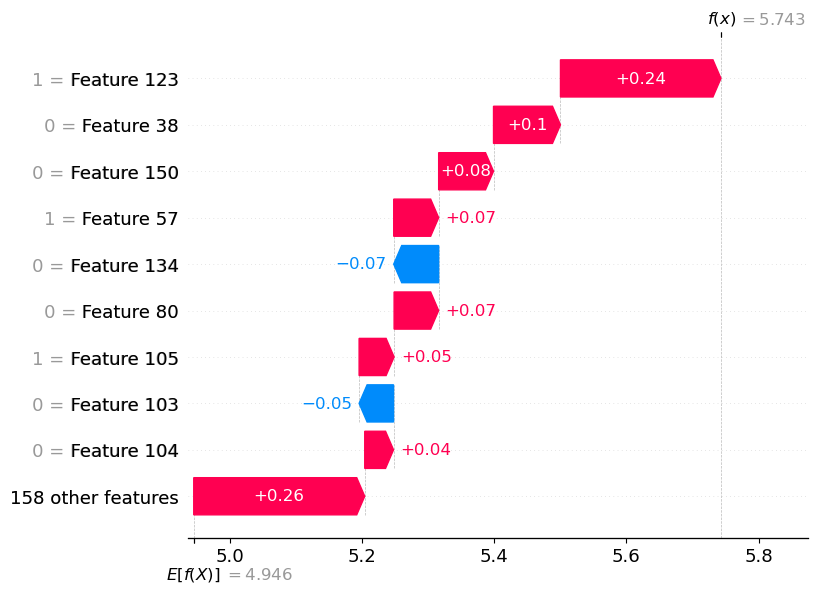

In [25]:
shap.plots.waterfall(shap_values[0])


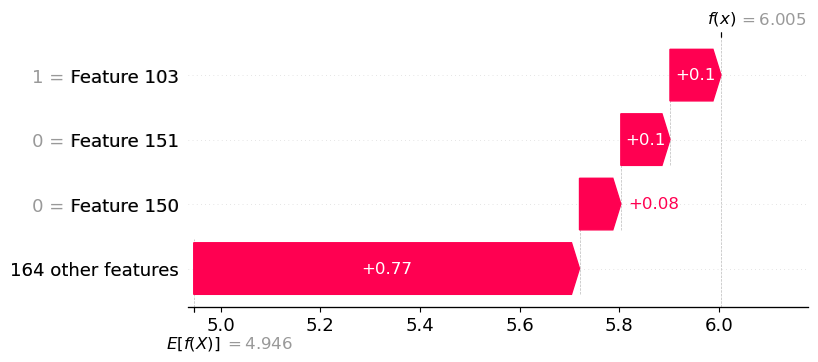

In [26]:
shap.plots.waterfall(shap_values[1], max_display=4)

# Force Plot

In [27]:
# a consended waterfall plot
shap.plots.force(shap_values[0])

# Stacked force plot
### Each of the individual force plots has been flipped 90 degrees and stacked side by side (vertically)

In [28]:
shap.plots.force(shap_values[0:100])

# Absolute Mean SHAP Plot
### Which features are most important to the MODEL
### Each bar gives absolute mean SHAP value for each feature. Features that have made large positive or negative contributions are at the top. 

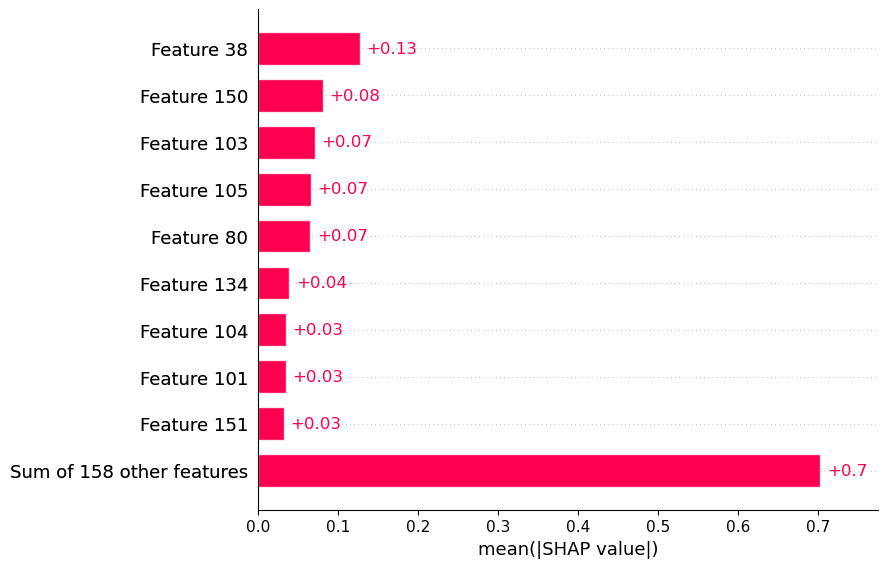

<Figure size 640x480 with 0 Axes>

In [29]:
shap.plots.bar(shap_values)
# save figure
plt.savefig('shap_plt_ABS_rand_TPE.png', dpi=300, bbox_inches='tight')

# Beeswarm Plot
### A visualisation of all of the SHAP values
### y axis: Feature #
### x axis: SHAP value
### colour: determined by the feature values 
### We can see which features have large positive or large negative SHAP values. Features have been ordered in same order in abs mean plot
### There is no gradient here as the feature value is binary [0,1]
### Feature 38: a value of 1 contributes to a negative SHAP value whilse for feature 103 this is the opposite. 

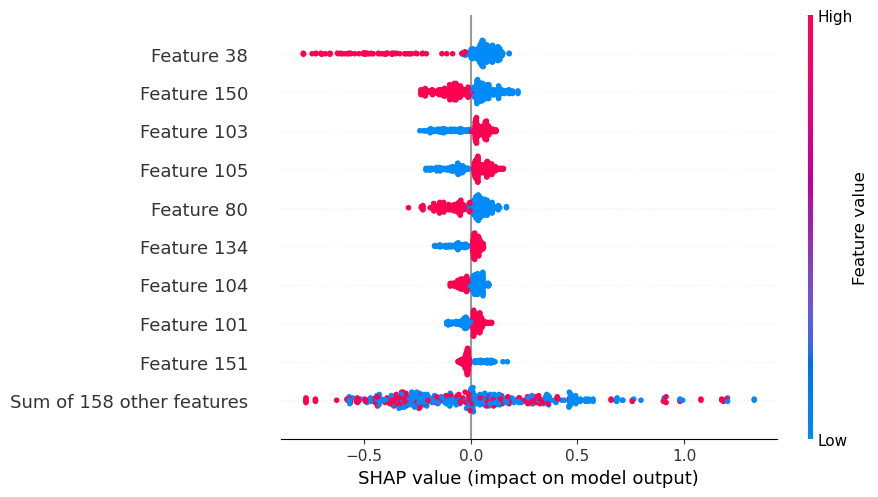

<Figure size 640x480 with 0 Axes>

In [30]:
shap.plots.beeswarm(shap_values)
# save figure
plt.savefig('shap_plt_beeswarm_rand_TPE.png', dpi=300, bbox_inches='tight')

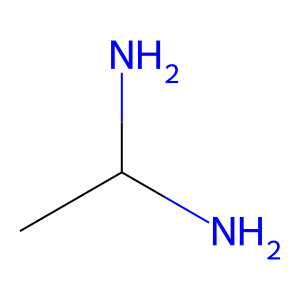

In [31]:
f38_smiles = 'NC(C)N'
f38_molecule = Chem.MolFromSmiles(f38_smiles)
Draw.MolToImage(f38_molecule)

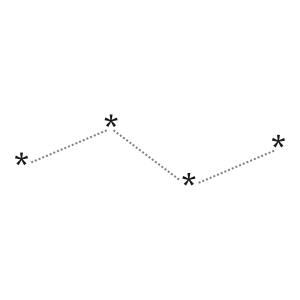

In [32]:
f105_smiles = '[*]~[*]~[*]~[*]'
f105_molecule = Chem.MolFromSmiles(f105_smiles)
Draw.MolToImage(f105_molecule)

In [33]:
# get the smiles string of the 5 molecules with the highest pIC50 values in the column compounds["f_avg_pIC50"]
top_molecules_df = compounds.sort_values(by="f_avg_pIC50", ascending=False).head(3)
top_SMILES = top_molecules_df["SMILES"].to_list()
top_CIDs = top_molecules_df["CID"].to_list()

# Generate the molecule objects from the SMILES strings
top_molecules = [Chem.MolFromSmiles(smiles) for smiles in top_SMILES]
print(f"SMILES of Molecules with the highest f_avg_pIC50 values: {top_molecules}")
print(f"CIDs of Molecules with the highest f_avg_pIC50 values: {top_CIDs}")

SMILES of Molecules with the highest f_avg_pIC50 values: [<rdkit.Chem.rdchem.Mol object at 0x16c0630d0>, <rdkit.Chem.rdchem.Mol object at 0x160de9700>, <rdkit.Chem.rdchem.Mol object at 0x160de83c0>]
CIDs of Molecules with the highest f_avg_pIC50 values: ['ALP-POS-c59291d4-5', 'NAU-LAT-356bd3c2-1', 'JOH-MSK-46727e7b-1']


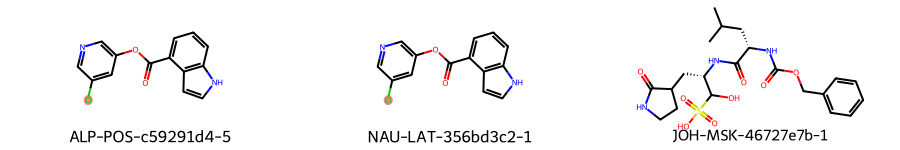

In [81]:
highlight103 = Chem.MolFromSmarts("Cl")
img103 = Draw.MolsToGridImage(
    top_molecules,
    molsPerRow=3,
    subImgSize=(300, 150),
    legends=top_CIDs,
    highlightAtomLists=[molecule.GetSubstructMatch(highlight103) for molecule in top_molecules],
)
display(img103)

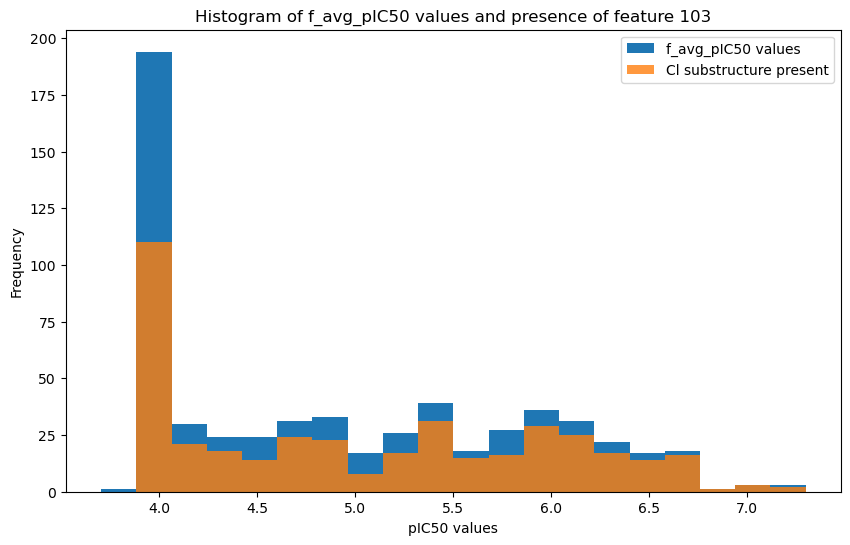

In [80]:

# Assuming compounds DataFrame is already defined and contains 'f_avg_pIC50' and 'SMILES' columns

# Create a new column indicating the presence of 'Cl' substructure
Cl_presence = compounds.copy()
Cl_presence['Cl_substructure'] = Cl_presence['SMILES'].str.contains('Cl')

plt.figure(figsize=(10, 6))
bins = np.histogram_bin_edges(Cl_presence["f_avg_pIC50"], bins=20)
plt.hist(Cl_presence["f_avg_pIC50"], bins=bins, label="f_avg_pIC50 values")
plt.hist(Cl_presence[Cl_presence["Cl_substructure"] == True]["f_avg_pIC50"], bins=bins, alpha=0.8, label="Cl substructure present")

plt.xlabel("pIC50 values")
plt.ylabel("Frequency")
plt.title("Histogram of f_avg_pIC50 values and presence of feature 103")
plt.legend()
plt.show()



In [ ]:
# plot the proprtion of molecules with the 'Cl' substructure in each bin
plt.figure(figsize=(10, 6))
bins = np.histogram_bin_edges(Cl_presence["f_avg_pIC50"], bins=20)
Cl_presence["f_avg_pIC50_bin"] = pd.cut(Cl_presence["f_avg_pIC50"], bins=bins)
Cl_presence["Cl_substructure"] = Cl_presence["Cl_substructure"].astype(int)
Cl_presence_grouped = Cl_presence.groupby("f_avg_pIC50_bin").agg({"Cl_substructure": "mean"}).reset_index()


In [36]:
highlight105 = Chem.MolFromSmarts("[*]~[*]~[*]~[*]")
highlight_color = (1.0, 1.0, 0.0)  # RGB for yellow
highlight_atom_lists= [molecule.GetSubstructMatch(highlight105) for molecule in top_molecules]
highlight_atom_lists_colour = [{atom_idx: highlight_color for atom_idx in match} for match in highlight_atom_lists]

img105 = Draw.MolsToGridImage(
    top_molecules,
    molsPerRow=3,
    subImgSize=(450, 200),
    legends=top_molecules_df["CID"].to_list(),
    highlightAtomLists=highlight_atom_lists,
    highlightAtomColors=highlight_atom_lists_colour 
)
display(img105)

# Highlighting the maximum common substructure of the 9 molecules (with highest pIC50 values)

In [37]:
# # Find the Maximum Common Substructure (MCS)
# mcs_result = rdFMCS.FindMCS(top_molecules)
# mcs_smarts = mcs_result.smartsString
# mcs_mol = Chem.MolFromSmarts(mcs_smarts)
# legends = top_CIDs

# top_highlighted_molecules = []
# for mol in top_molecules:
#     # Get the atom indices of the MCS in the molecule
#     match = mol.GetSubstructMatch(mcs_mol)
#     # Highlight the MCS
#     top_highlighted_molecules.append((mol, match))

# img = Draw.MolsToGridImage(
#     [mol for mol, match in top_highlighted_molecules],
#     molsPerRow=3,
#     subImgSize=(450, 200),
#     legends=legends,
#     highlightAtomLists=[match for mol, match in top_highlighted_molecules]
# )
# display(img)

# # Convert the MCS to a SMILES string and print it
# mcs_smiles = Chem.MolToSmiles(mcs_mol)
# print(f"Maximum Common Substructure (MCS) as SMILES: {mcs_smiles}")

# What is going on here ?

In [38]:
#These 3D strucutres are not accurate

# mol3Ds = []

# for smiles_string in top_SMILES:
#     mymol = mol3D()
#     mymol.read_smiles(smiles_string)
#     mol3Ds += [mymol]

# view_structures(mol3Ds, w=300, h=300, columns=3)


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

# Relative feature importance with Random Forest

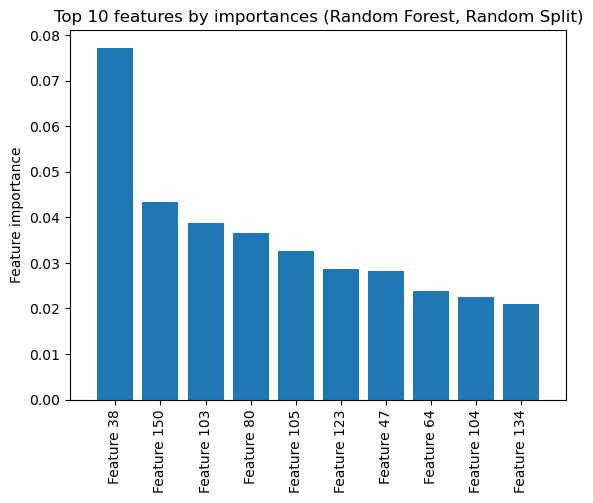

<Figure size 640x480 with 0 Axes>

In [39]:
# import matplotlib.pyplot as plt
# import numpy as np

# Assuming rfr_rand_best_TPE and x_train_rand are already defined
importances = rfr_rand_best_TPE_MACCS.feature_importances_

# Get the indices of the top 10 features
top_10_indices = np.argsort(importances)[-10:][::-1]

# Get the top 10 importances and feature names
top_10_importances = importances[top_10_indices]
top_10_feature_names = [f"Feature {i}" for i in top_10_indices]
plt.title("Top 10 features by importances (Random Forest, Random Split)")
plt.ylabel("Feature importance")

# Plot bar chart of the top 10 feature importances in descending order
plt.bar(range(10), top_10_importances, align="center")
plt.xticks(range(10), top_10_feature_names, rotation=90)
plt.xlim([-1, 10])
plt.show()

#save plot
plt.savefig('top_10_features_importances_rand_TPE.png', dpi=300, bbox_inches='tight')

### Shap and random forest feature importance seem to agree on the top 4 most important features.

The most common pIC50 value is: 4.002176919254275 and appears 188 times


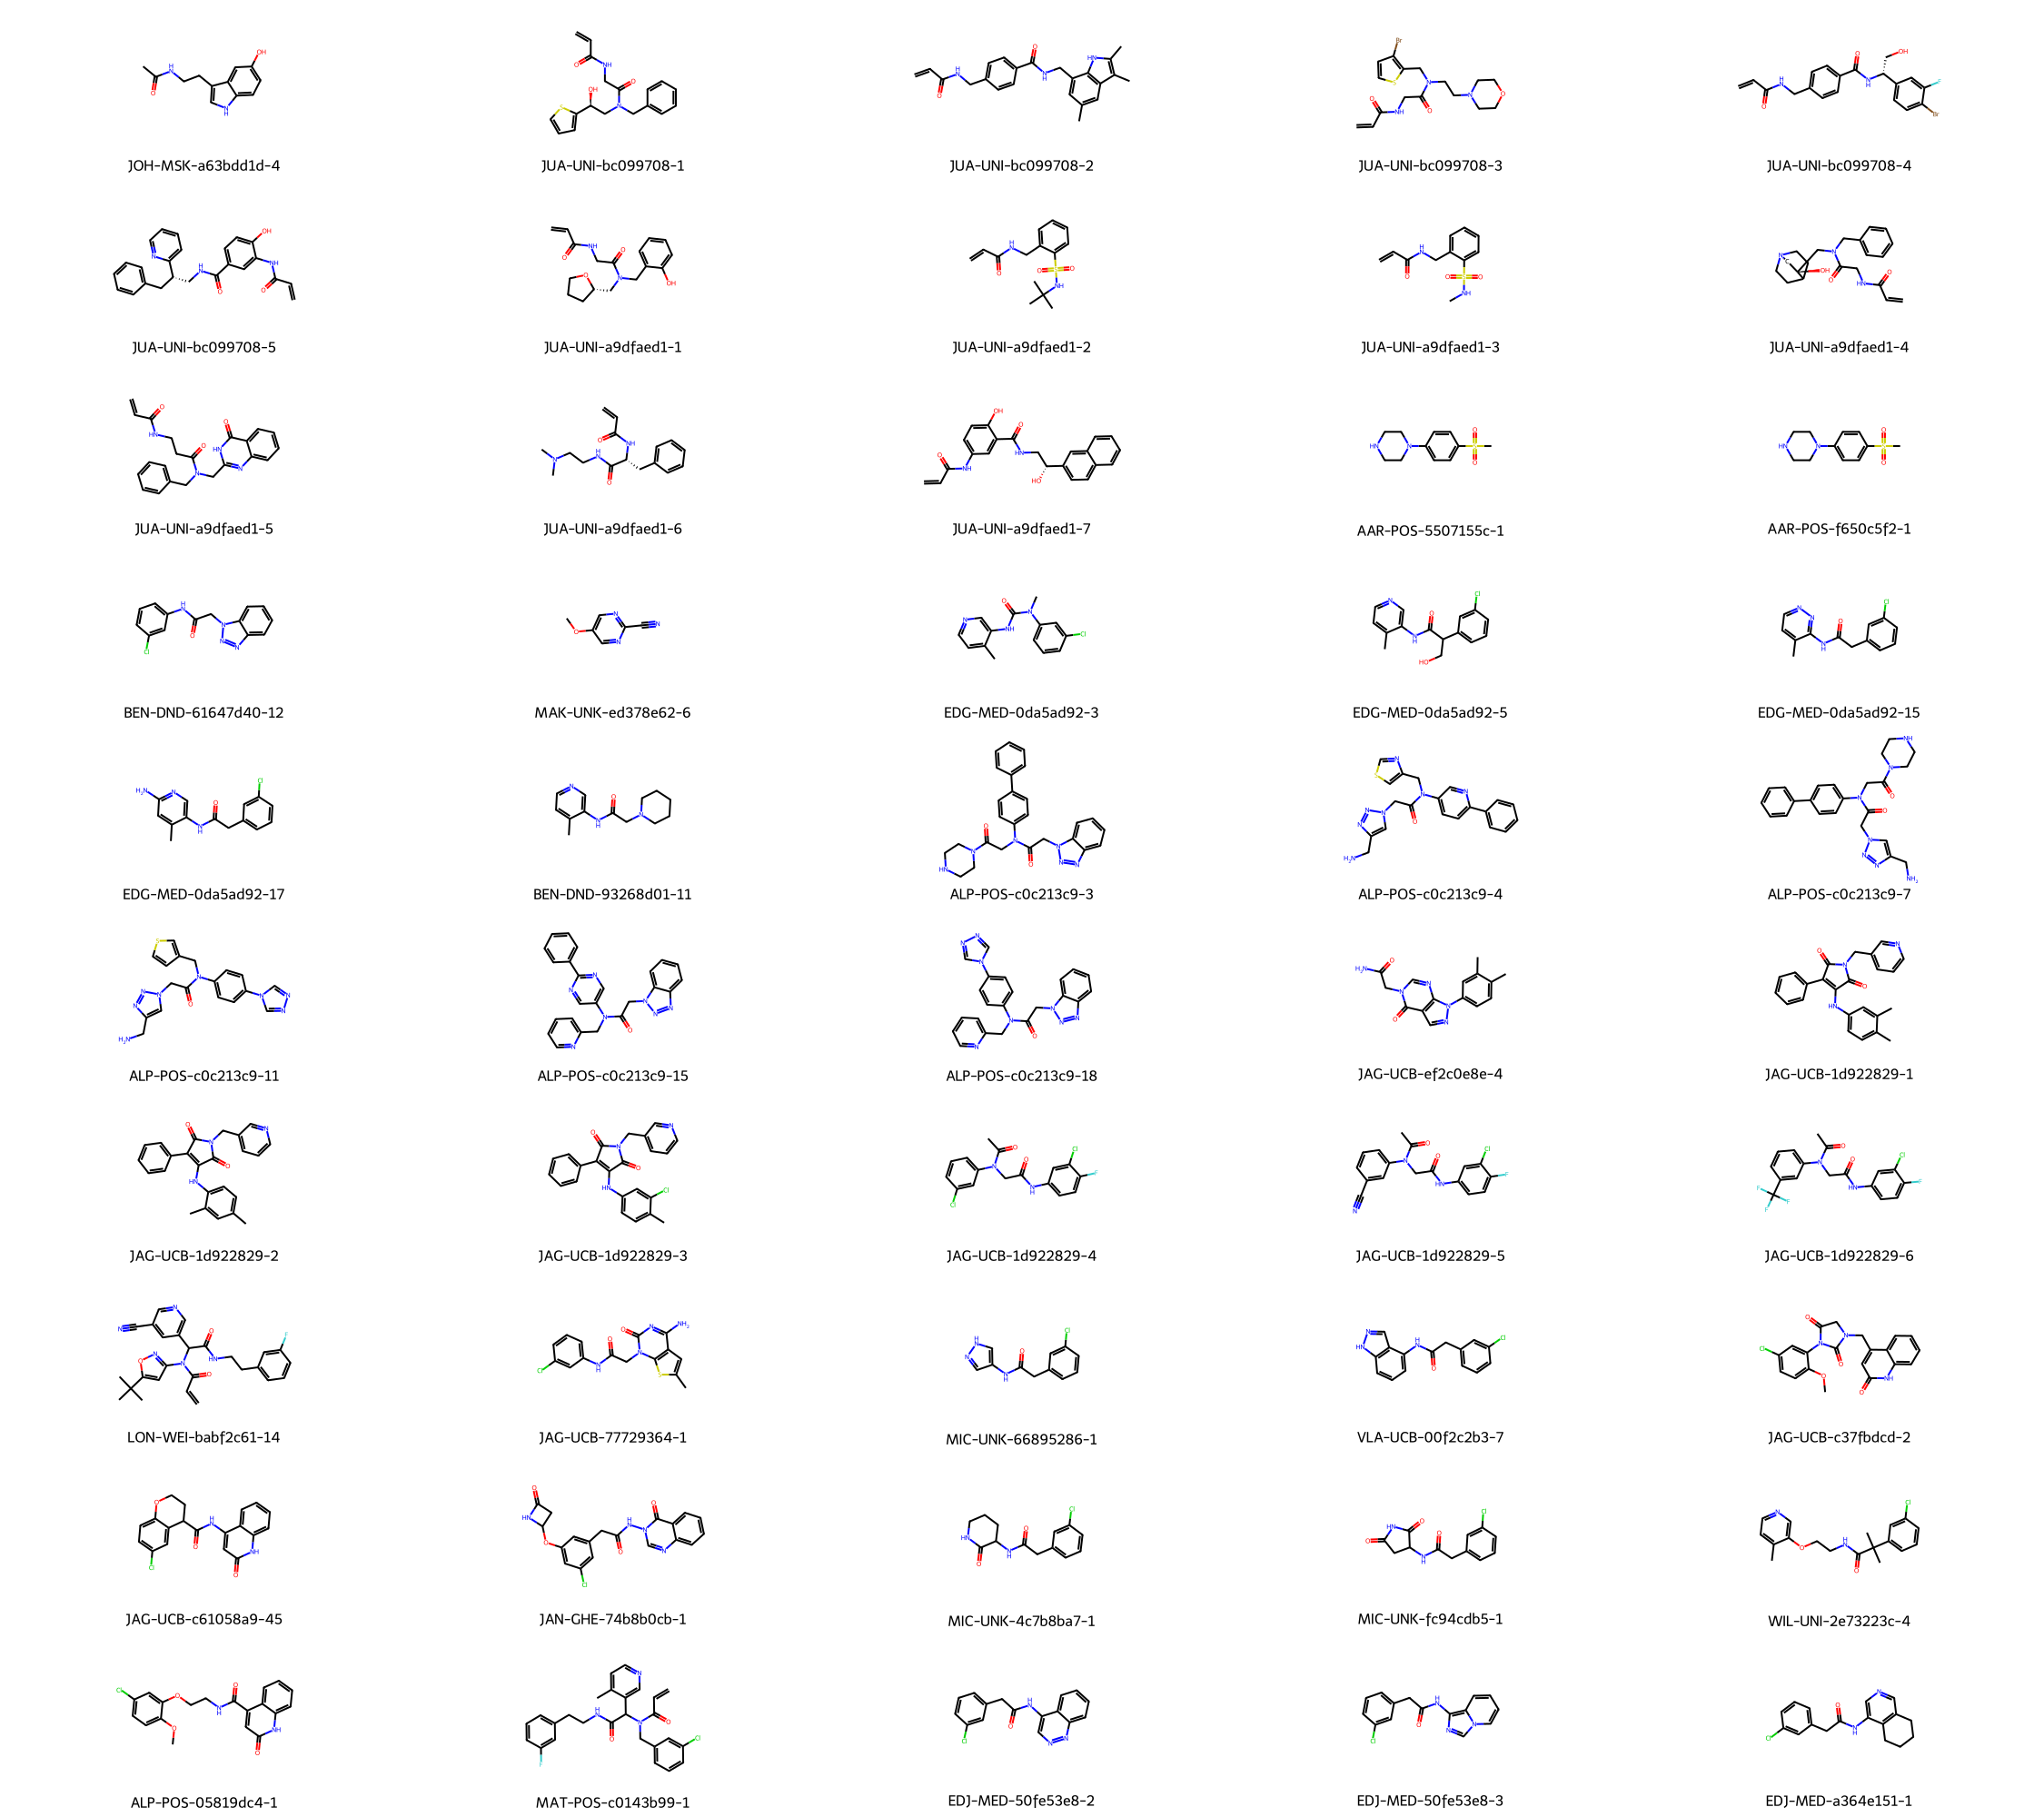

In [40]:
# find the most commont pIC50 value 
mc_pIC50 = compounds["f_avg_pIC50"].mode()[0]
print(f"The most common pIC50 value is: {mc_pIC50} and appears {compounds['f_avg_pIC50'].value_counts().max()} times")

# 2D visualisations of 30 of these molecules
# Get the SMILES strings of the 30 molecules with the most common pIC50 value
mc_pIC50_molecules_df = compounds[compounds["f_avg_pIC50"] == mc_pIC50].head(50)
mc_pIC50_molecules_SMILES = mc_pIC50_molecules_df["SMILES"].to_list()
mc_pIC50_molecules_CIDs = mc_pIC50_molecules_df["CID"].to_list()

# Generate the molecule objects from the SMILES strings
mc_pIC50_molecules = [Chem.MolFromSmiles(smiles) for smiles in mc_pIC50_molecules_SMILES]

imgmcpIC50 = Draw.MolsToGridImage(
    mc_pIC50_molecules ,
    molsPerRow=5,
    subImgSize=(450, 200),
    legends=mc_pIC50_molecules_CIDs,
)
display(imgmcpIC50)

# Furthest Cluster Split

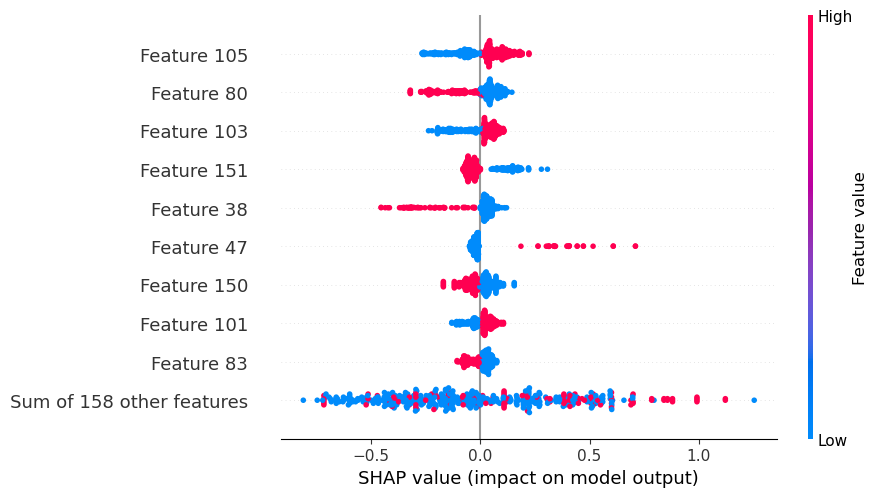

<Figure size 640x480 with 0 Axes>

In [41]:
shap.plots.beeswarm(shap_values_fur)
# save figure
plt.savefig('shap_plt_beeswarm_fur_TPE.png', dpi=300, bbox_inches='tight')